In [1]:
# main.py

import backtrader as bt
import pandas as pd
from strategies.ma_strategy import MovingAverageStrategy
import matplotlib.pyplot as plt


In [2]:
# === Parameters ===
SHORT_WINDOW = 500  # Short-term moving average
LONG_WINDOW = 2000  # Long-term moving average

In [3]:
# Data path
file_path = './data/BTCUSD.csv'

start_date = '2022-01-22T00:00:00+00:00'
end_date = '2022-09-12T04:00:00+00:00'

df = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')

filtered_df = df.loc[start_date:end_date].copy()

filtered_df.rename(columns={'price': 'close'}, inplace=True)

# Ensure necessary columns exist
required_columns = {'close', 'open', 'high', 'low', 'volume'}
if not required_columns.issubset(filtered_df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(filtered_df.columns)}")


In [4]:
# === Calculate Moving Averages ===
filtered_df['SMA50'] = filtered_df['close'].rolling(window=SHORT_WINDOW, min_periods=SHORT_WINDOW).mean()
filtered_df['SMA200'] = filtered_df['close'].rolling(window=LONG_WINDOW, min_periods=LONG_WINDOW).mean()

df = filtered_df.copy()

# === Remove Rows with NaN SMAs ===
# filtered_df = filtered_df.dropna(subset=['SMA50', 'SMA200']).copy()

In [5]:

# Constants
TRADE_FEE = 0.001  # 0.1% per trade
PROFIT_TARGET = 0.005  # 0.5% profit target
INITIAL_CAPITAL = 100  # Starting balance

# Backtesting Variables
current_position = 0  # 0 = no position, 1 = holding
entry_price = None
balance = INITIAL_CAPITAL
portfolio_value = INITIAL_CAPITAL
uptrend_triggered = False  # Tracks if uptrend has been triggered
trade_log = []  # Track detailed trade history

# Add required columns
df['Signal'] = 0  # Default to no position
df['Entry_Price'] = None  # Track entry price for profitability check
df['Action'] = None  # Log actual actions
df['Portfolio_Value'] = INITIAL_CAPITAL

def calculate_sell_price(entry_price, profit_target, trade_fee):
    return entry_price * (1 + profit_target + (2 * trade_fee))

for i in range(1, len(df)):
    current_price = df['close'].iloc[i]
    sma50 = df['SMA50'].iloc[i]
    sma200 = df['SMA200'].iloc[i]
    
    # Ensure SMAs are valid
    if pd.isna(sma50) or pd.isna(sma200):
        continue
    
    # BUY Condition: SMA50 > SMA200 and no active position, only buy once per uptrend
    if sma50 > sma200 and current_position == 0 and not uptrend_triggered:
        df.at[df.index[i], 'Signal'] = 1
        df.at[df.index[i], 'Entry_Price'] = current_price
        df.at[df.index[i], 'Action'] = 'BUY'
        current_position = 1
        entry_price = current_price
        balance = 0  # All money is invested
        uptrend_triggered = True  # Mark uptrend as triggered
        trade_log.append({'Type': 'BUY', 'Price': current_price, 'Date': df.index[i], 'Balance': balance})
    
    # SELL Condition: Achieve 0.5% profit after fees
    if current_position == 1:
        target_sell_price = calculate_sell_price(entry_price, PROFIT_TARGET, TRADE_FEE)
        if current_price >= target_sell_price:
            df.at[df.index[i], 'Signal'] = 0
            df.at[df.index[i], 'Action'] = 'SELL'
            profit = (current_price - entry_price) * (1 - 2 * TRADE_FEE)
            balance += (INITIAL_CAPITAL + profit)
            current_position = 0
            entry_price = None
            trade_log.append({'Type': 'SELL', 'Price': current_price, 'Date': df.index[i], 'Profit': profit, 'Balance': balance})
    
    # Reset uptrend_triggered when trend reverses
    if sma50 <= sma200:
        uptrend_triggered = False
    
    # Update portfolio value
df['Portfolio_Value'] = balance

# === Performance Metrics ===
initial_price = df['close'].iloc[0]
final_price = df['close'].iloc[-1]
buy_and_hold_return = final_price / initial_price
strategy_final = balance
benchmark_final = INITIAL_CAPITAL * buy_and_hold_return
crypto_balance = (entry_price * (1 - TRADE_FEE)) if current_position == 1 else 0
virtual_balance = strategy_final + crypto_balance
comparison = "outperformed" if strategy_final > benchmark_final else "underperformed"

# Display Results
print(f"Final Portfolio Value (Strategy after Fees): ${strategy_final:.2f}")
print(f"Final Crypto Balance (Unrealized Value): ${crypto_balance:.2f}")
print(f"Final Virtual Portfolio Value (Including Unrealized Crypto): ${virtual_balance:.2f}")
print(f"Final Portfolio Value (Buy-and-Hold): ${benchmark_final:.2f}")
print(f"The strategy has {comparison} the Buy-and-Hold benchmark by ${strategy_final - benchmark_final:.2f}.")

Final Portfolio Value (Strategy after Fees): $395.66
Final Crypto Balance (Unrealized Value): $0.00
Final Virtual Portfolio Value (Including Unrealized Crypto): $395.66
Final Portfolio Value (Buy-and-Hold): $103.77
The strategy has outperformed the Buy-and-Hold benchmark by $291.89.


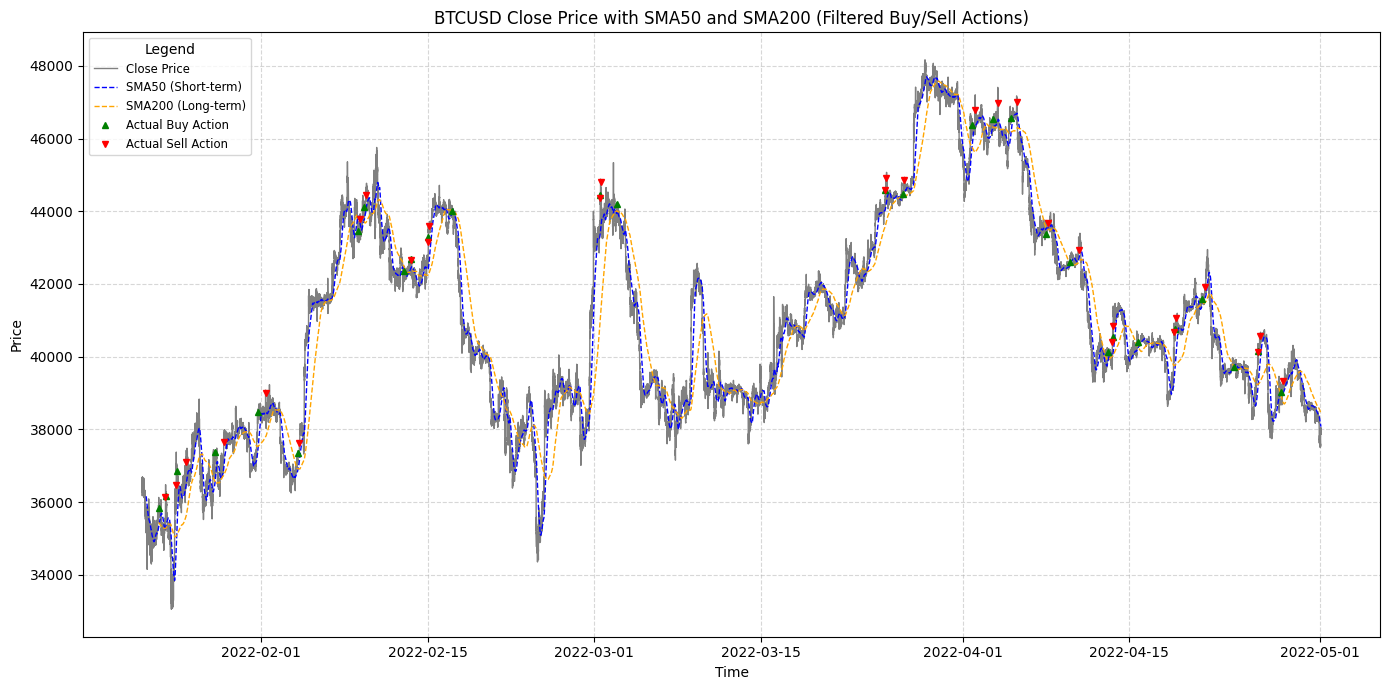

In [6]:
# === Visualization ===
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Close Price', linewidth=1, color='gray')
plt.plot(df.index, df['SMA50'], label='SMA50 (Short-term)', linestyle='--', linewidth=1, color='blue')
plt.plot(df.index, df['SMA200'], label='SMA200 (Long-term)', linestyle='--', linewidth=1, color='orange')

# Plot Buy Actions
plt.plot(
    df.index[df['Action'] == 'BUY'],
    df['close'][df['Action'] == 'BUY'],
    '^', color='green', markersize=4, label='Actual Buy Action'
)

# Plot Sell Actions
plt.plot(
    df.index[df['Action'] == 'SELL'],
    df['close'][df['Action'] == 'SELL'],
    'v', color='red', markersize=4, label='Actual Sell Action'
)

# Plot Titles and Legend
plt.title('BTCUSD Close Price with SMA50 and SMA200 (Filtered Buy/Sell Actions)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize='small', title='Legend', title_fontsize='medium')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
